## Introduction
Over 4 million host share their homes on Airbnb, which is more than the top five hotel brands combined (according Business Insider). Of course, if you want to travel anywhere in the world the first stop is Airbnb.

In this analysis, we will explore a Seattle dataset of AirBnb, and compare it with Boston dataset. We will use two datasets in this analysis: description and features of homes and the availability and price per day.
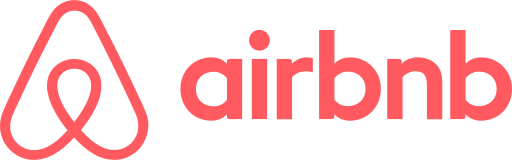

I propose three questions to explore, based on — availability, price and features (and the relation with price). Specifically:
1. How many days are homes available vs. not available to rent? Is there any seasonality? How can we compare it in both cities?
2. What is the behavior of renting price in each city? And how is it compare it between both cities
3. Is there any feature in homes that predict the price for Seattle?

In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
#import test3 as t
import seaborn as sns
%matplotlib inline

## Exploratory Data Analysis

#### Data Understanding and preparation
I will load the data and according its structure I will propose some transformation to manipule it in the best way possible

In [308]:
df_S= pd.read_csv('./calendarS.csv')
df_S['month_day']=df_S['date'].str[5:]
df_S.head()

,listing_id,date,available,price,month_day
0,241032,2016-01-04,t,$85.00,01-04
1,241032,2016-01-05,t,$85.00,01-05
2,241032,2016-01-06,f,NaN,01-06
3,241032,2016-01-07,f,NaN,01-07
4,241032,2016-01-08,f,NaN,01-08


In [309]:
df_B= pd.read_csv('./calendarB.csv')
df_B['month_day']=df_B['date'].str[5:]
df_B.head()

,listing_id,date,available,price,month_day
0,12147973,2017-09-05,f,NaN,09-05
1,12147973,2017-09-04,f,NaN,09-04
2,12147973,2017-09-03,f,NaN,09-03
3,12147973,2017-09-02,f,NaN,09-02
4,12147973,2017-09-01,f,NaN,09-01


Since the dataset in seattle and boston are not in the same timeframe (but it is a year), I decided to create a new field called month_day, cutting the year. with this new field we will be able to compare both dataset and its seasonality, trend etc in a better way.

In [310]:
df_B['date'].max()

'2017-09-05'

In [311]:
df_S.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
 4   month_day   1393570 non-null  object
dtypes: int64(1), object(4)
memory usage: 53.2+ MB


the price is a string becasue it has a $ sign. So I create a function that transform the field into a float

In [312]:
def clean_price(df, col):
    '''
    the goal is to clean price data and transform it from string to float
    input:
    df: dataframe
    col: specific column to transform
    '''
    df[col]=df[col].str.replace('$','').replace(',','')
    df[col]=df[col].str.replace(',','')
    df[col]=df[col].astype(float)

In [313]:
#Let's clean the data
# 1st price (transform to number)
#clean_price(df_S,'price','$')
clean_price(df_S, 'price')
clean_price(df_B, 'price')

# 2nd date, group by year-month
#df_S['date']=pd.to_datetime(df_S['date'])
#df_S['y_m']=df_S['date'].dt.strftime('%Y-%m')

#df_B['date']=pd.to_datetime(df_B['date'])
#df_B['y_m']=df_B['date'].dt.strftime('%Y-%m')


In [314]:
df_S.head()

,listing_id,date,available,price,month_day
0,241032,2016-01-04,t,85.0,01-04
1,241032,2016-01-05,t,85.0,01-05
2,241032,2016-01-06,f,NaN,01-06
3,241032,2016-01-07,f,NaN,01-07
4,241032,2016-01-08,f,NaN,01-08


In [315]:
#now we have a float field in price, so we can describe it in a better way
df_S.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   listing_id  1393570 non-null  int64  
 1   date        1393570 non-null  object 
 2   available   1393570 non-null  object 
 3   price       934542 non-null   float64
 4   month_day   1393570 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 53.2+ MB


In [316]:
# number of homes during this year
len(pd.unique(df_S['listing_id'])) 

3818

In [317]:
len(pd.unique(df_B['listing_id'])) 

3585

### Data Modeling
Since the data is ok, we will start with some descriptive analysis and try to understand the behavior of the dataset to answer the questions

In [318]:
# available homes in Airbnb during the year
df_S_ava=df_S[df_S['available']=='t']
df_S_ga=df_S_ava.groupby(['month_day'])['listing_id'].count()
df_S_ga=df_S_ga.reset_index()
df_S_ga['av']=df_S_ga['listing_id']/len(pd.unique(df_S['listing_id']))
df_S_ga['type']='Seattle'

df_B_ava=df_B[df_B['available']=='t']
df_B_ga=df_B_ava.groupby(['month_day'])['listing_id'].count()
df_B_ga=df_B_ga.reset_index()
df_B_ga['av']=df_B_ga['listing_id']/len(pd.unique(df_B['listing_id']))
df_B_ga['type']='Boston'

In [319]:
df_S_ga['listing_id'].describe()

count     365.000000
mean     2560.389041
std       182.879102
min      1735.000000
25%      2471.000000
50%      2577.000000
75%      2682.000000
max      2922.000000
Name: listing_id, dtype: float64

In [320]:
df_B_ga['listing_id'].describe()

count     365.000000
mean     1761.745205
std       273.240049
min       570.000000
25%      1738.000000
50%      1771.000000
75%      1946.000000
max      2207.000000
Name: listing_id, dtype: float64

#### Insights
the first point is that Airbnb homes in Seattle have more availability than Boston (compare it mean) and mode stable (in terms of std) and number of total homes.

In [321]:
df_B_ga.loc[df_B_ga['av']==df_B_ga['av'].max()]

,month_day,listing_id,av,type
337,12-04,2207,0.615621,Boston


In [322]:
print("Percentage available")
print("Seattle:",df_S_ga['listing_id'].mean()/len(pd.unique(df_S['listing_id'])))
print("Boston:",df_B_ga['listing_id'].mean()/len(pd.unique(df_B['listing_id'])))

Percentage available
Seattle: 0.6706100160020666
Boston: 0.4914212567585641


[(0.0, 1.0)]

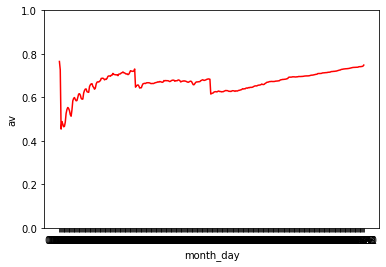

In [323]:
# daily evolution of available homes during 2016
ax=sns.lineplot(data=df_S_ga,x='month_day', y='av', color='red')
ax.set(ylim=(0, 1))

[(0.0, 1.0)]

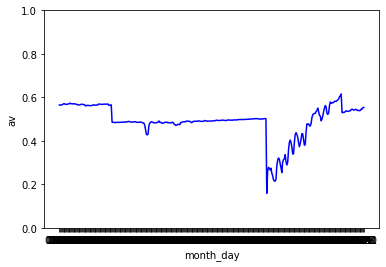

In [324]:
ax=sns.lineplot(data=df_B_ga,x='month_day', y='av', color='blue')
ax.set(ylim=(0, 1))

#### Insights
comparing the plots:
Seattle has a higher available rate than Boston (around 67% vs 49%), in addition the trend show that Seattle has a small but positive trend that indicates more people with available homes for rent. In the opposite side, Boston has a very flat availability rate (except between August and September). Another insight from the data is that Seattle has a peak in availability at the end and beginning of the year, however Boston is maintain the higher available rate between December and March.

### distribution of homes availability during the year

In [325]:
# Unavailable homes the entire year
print('homes without any availability in seattle:', len(pd.unique(df_S['listing_id']))-len(pd.unique(df_S_ava['listing_id'])),'/', (len(pd.unique(df_S['listing_id']))-len(pd.unique(df_S_ava['listing_id'])))/len(pd.unique(df_S['listing_id'])) )
print('homes without any availability in boston:', len(pd.unique(df_B['listing_id']))-len(pd.unique(df_B_ava['listing_id'])),'/', (len(pd.unique(df_B['listing_id']))-len(pd.unique(df_B_ava['listing_id'])))/len(pd.unique(df_B['listing_id'])) )

homes without any availability in seattle: 95 / 0.024882137244630696
homes without any availability in boston: 679 / 0.1894002789400279


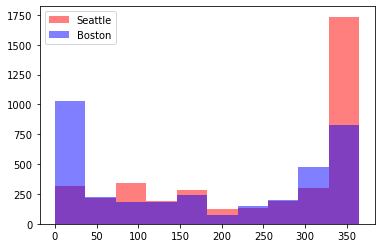

In [326]:
df_B_1=df_B.groupby('listing_id')['price'].count()
df_B_1=df_B_1.reset_index()
df_S_1=df_S.groupby('listing_id')['price'].count()
df_S_1=df_S_1.reset_index()

plt.hist(df_S_1['price'], color='red', label='Seattle', alpha=0.5)
plt.hist(df_B_1['price'], color='blue', label='Boston', alpha=0.5)


plt.legend()
plt.show()


#### insights
1.-homes without any availability all year in Seattle: 95 → 2.49% of total homes
2.-homes without any availability all year in Boston: 679 → 18.94% of total homes

When we see the histogram of how many days are available each home (during the year), we see that homes from Seattle homes are almost all year available, in the opposite side in Boston there are many homes with no or few days available days during the year.


### pricing

In [327]:
# mean price homes in Airbnb during the year
df_S_ga2=df_S_ava.groupby(['month_day'])['price'].mean()
df_S_ga2=df_S_ga2.reset_index()

df_B_ga2=df_B_ava.groupby(['month_day'])['price'].mean()
df_B_ga2=df_B_ga2.reset_index()

In [328]:
df_S_ava['price'].describe()

count    934542.000000
mean        137.944859
std         105.062870
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

In [329]:
df_B_ava['price'].describe()

count    643037.000000
mean        198.438909
std         180.142913
min          11.000000
25%          85.000000
50%         150.000000
75%         255.000000
max        7163.000000
Name: price, dtype: float64

In [330]:
print("mean price")
print("Seattle:",df_S_ava['price'].mean())
print("Boston:",df_B_ava['price'].mean())

mean price
Seattle: 137.94485855103355
Boston: 198.43890942511862


The mean of price in Seattle is lower than Boston, with 137.9 usd per night vs 198.4 (in Boston), this point could be related with the availability of the total homes capacity. In addition, it is interesting that the prices in Seattle are flatter than Boston (lower std).

[(0.0, 300.0)]

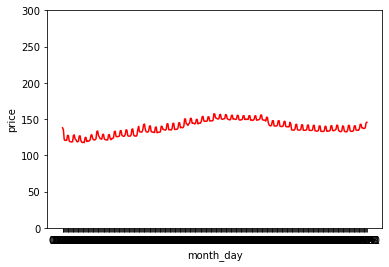

In [331]:
ax=sns.lineplot(data=df_S_ga2,x='month_day', y='price', color='red')
ax.set(ylim=(0, 300))

[(0.0, 300.0)]

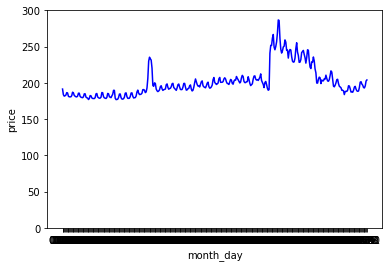

In [332]:
ax=sns.lineplot(data=df_B_ga2,x='month_day', y='price', color='blue')
ax.set(ylim=(0, 300))

When we see the evolution of prices during the year, we notice that prices, in Seattle, do not move with homes availability, however, in Boston we see that when the price goes up is the same moment that available homes go down. This fact shows that Boston is take into account the change in the market quickly (lower offer (with the same demand), higher prices).

According evolution of prices, Seattle does not show any trend with a small seasonality during the end of autumn. In the other side Boston shows a small increased price effect with 2 peaks, at the end of the year and during the second quarter, both peaks related with less availability of homes.

## Can we predict or at least say key varibles that change the price?

#### data understanding and preparation

In [333]:
df_SL= pd.read_csv('./listingsS.csv')
df_SL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [334]:
df_SL.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [335]:
#convert price to float --> using the function that I created before
clean_price(df_SL, 'price')

df_SL['price']

0        85.0
1       150.0
2       975.0
3       100.0
4       450.0
        ...  
3813    359.0
3814     79.0
3815     93.0
3816     99.0
3817     87.0
Name: price, Length: 3818, dtype: float64

In [336]:
df_SL['price'].mean() # average price in the file

127.97616553169199

### Data Modeling
We will explore the relationship between price and other variables to identify any correlation between them and try to predict price when we know some home features 

In [337]:
df_SL.corr()['price']

id                               -0.046289
scrape_id                              NaN
host_id                          -0.051332
host_listings_count               0.093962
host_total_listings_count         0.093962
latitude                         -0.008904
longitude                        -0.102420
accommodates                      0.652218
bathrooms                         0.516424
bedrooms                          0.627720
beds                              0.589525
square_feet                       0.531752
price                             1.000000
guests_included                   0.392875
minimum_nights                    0.017297
maximum_nights                   -0.003336
availability_30                  -0.037653
availability_60                  -0.049336
availability_90                  -0.058810
availability_365                 -0.015550
number_of_reviews                -0.124695
review_scores_rating              0.055551
review_scores_accuracy            0.019026
review_scor

the higher correlation between price is with accommodates, bathrooms, bedrooms, beds, guests_included sqare fit. So let's see the behavior of each variable with price


#### Let's see explore what variables change the price

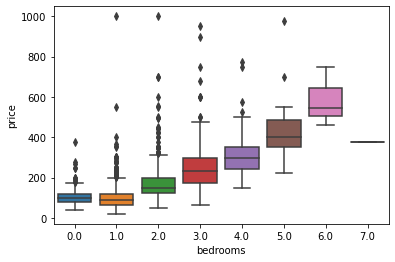

In [338]:
sns.boxplot(y='price',x='bedrooms',data=df_SL)

it is clear that the number of bedrooms move the price of a home, even when we more variability when we increase the number of bedrooms the trend is clear

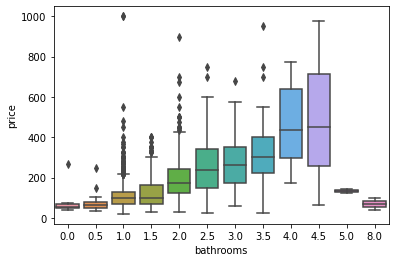

In [339]:
sns.boxplot(y='price',x='bathrooms',data=df_SL)

like the previous plot the number of bathrooms is highly correlated with price, however we see more variability than previous plot

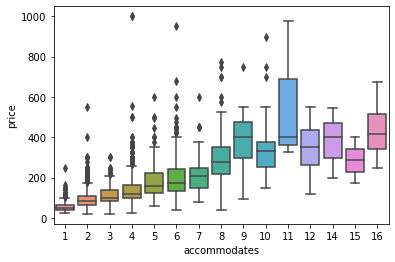

In [340]:
sns.boxplot(y='price',x='accommodates',data=df_SL)

accommodates shows a correlation with price, even when from 12+ drop the price

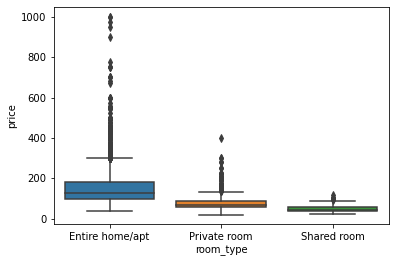

In [341]:
sns.boxplot(y='price',x='room_type',data=df_SL)

we see some differences between the room type, that make sense and differentiate the price

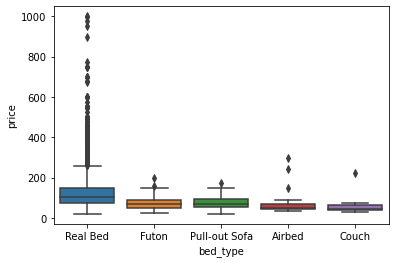

In [342]:
sns.boxplot(y='price',x='bed_type',data=df_SL)

like the previous plot we see some difference in price when we compare the different type of beds

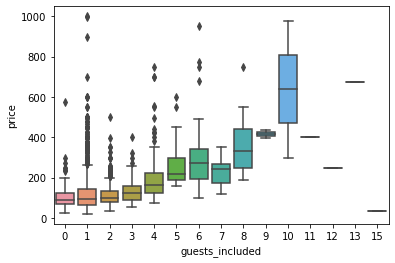

In [343]:
sns.boxplot(y='price',x='guests_included',data=df_SL)

finally, guests included feature is also correlated with price. It is important here to see that for more than 10, we do not have too much data

#### regression model
so we have 3.818 entries and in general is a completed database, with not much missing values (excluding square fit). we don't have missing values for price.
for the independent variables we can see that there is a low level of missing values less than 0.6% (Accommodates, bathrooms, bedrooms, room type), so the decision was to drop missing values and left a dataframe with 3.796 entries


In [344]:
df_analysis=df_SL.dropna(subset=['accommodates',
                                 'bathrooms',
                                 'bedrooms',
                                 'room_type',
                                 'price']) 

In [345]:
df_analysis[['accommodates','bathrooms','bedrooms','room_type','price']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3796 entries, 0 to 3817
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   accommodates  3796 non-null   int64  
 1   bathrooms     3796 non-null   float64
 2   bedrooms      3796 non-null   float64
 3   room_type     3796 non-null   object 
 4   price         3796 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 177.9+ KB


In [346]:
X = df_analysis[['accommodates',
                 'bathrooms',
                 'bedrooms',
                     'room_type']]
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,accommodates,bathrooms,bedrooms,room_type_Private room,room_type_Shared room
0,4,1.0,1.0,0,0
1,4,1.0,1.0,0,0
2,11,4.5,5.0,0,0
3,3,1.0,0.0,0,0
4,6,2.0,3.0,0,0


In [347]:
Y = df_analysis['price']

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [349]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [350]:
print(model.intercept_)

39.419664697661446


In [351]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
accommodates,7.803261
bathrooms,31.347372
bedrooms,29.902472
room_type_Private room,-47.276785
room_type_Shared room,-74.178159


According the table above, Bathrooms and bedrooms have similar impact in price, in other words when a home has an extra bathroom or bedroom the price will be increased around us$30 per day. At the opposite side when you have to share room you will pay US$74 less per day than when you rent an entire house/apt.

In [352]:
predictions = model.predict(X_test)
predictions

array([124.07929099,  86.37355827, 192.99806676, ..., 161.78502371,
       161.78502371, 191.68749567])

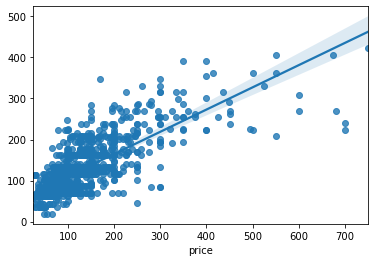

In [353]:
sns.regplot(x=y_test,y=predictions)


In [354]:
r2_score(y_test, predictions)

0.5781815579170664

The results of model explain almost 60% of the behavior of price, as detailed in chart above, compare it real price data point (blue dots) with the model prediction (line)

In [355]:
import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm.astype(float)).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     544.3
Date:                Sun, 10 Jan 2021   Prob (F-statistic):               0.00
Time:                        09:01:13   Log-Likelihood:                -14819.
No. Observations:                2657   AIC:                         2.965e+04
Df Residuals:                    2651   BIC:                         2.968e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     39